In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

## Reading the data

In [2]:
recipes = pd.read_parquet("recipes.parquet.gzip") 
entities = pd.read_parquet("entities.parquet.gzip")
relations = pd.read_parquet("relations.parquet.gzip")

In [3]:
sectors = pd.read_parquet("entities_with_sector.parquet(1).gzip") 
sectors.head()

,index,entity,revenue,imputed,deliveries_received,deliveries_made,unexplained_deliveries,final_demand,name,sector
0,0,32696,670.770794,True,0.0,50.307810,0.0,620.462984,Iochpe-Maxion SA,Producer Manufacturing
1,1,5268,8842.000000,False,0.0,1679.980000,0.0,7162.020000,"Autoliv, Inc.",Producer Manufacturing
2,2,28382,670.770794,True,0.0,137.977552,0.0,532.793242,Burelle SA,Producer Manufacturing
3,3,308172,1918.958043,False,0.0,211.085385,0.0,1707.872658,Gentex Corp.,Producer Manufacturing
4,4,326027,17489.000000,False,0.0,3322.910000,0.0,14166.090000,Aptiv Plc,Producer Manufacturing


## Supply and demand shocks

In [4]:
isics = pd.read_csv("ISIC_Walmart.csv", sep =';')
print(isics['WIOD code'].unique())
isics

['C29' 'C22' 'H49' 'C27' 'None' 'C25' 'C24' 'C28' 'J61' 'L68' 'J58' 'C10'
 'C17' 'C20' 'C13' 'C32' 'G46' 'C14' 'C21' 'H52' 'C26' 'C11' 'A01' 'C15'
 'K64' 'C12' 'C16' 'C31' 'J59' 'G47' 'J63' 'N' 'H51' 'J62' 'Q' 'H50' 'C18'
 'K65']


,Name,WIOD code
0,Iochpe-Maxion SA,C29
1,"Autoliv, Inc.",C29
2,Burelle SA,C22
3,Gentex Corp.,C29
4,Aptiv Plc,C29
...,...,...
218,"BBK Electronics Corp., Inc.",C26
219,Paris Saint-Germain Football SA,Q
220,"Nice-Pak Products, Inc.",C17
221,FKA Distributing Co. LLC,G46


In [5]:
supply_shocks = np.zeros(223)
for i in range(0,223):
    if isics.iloc[i,1] == 'C29':
        supply_shocks[i] = 69.7
    elif isics.iloc[i,1] == 'C22':
        supply_shocks[i] = 35.3
    elif isics.iloc[i,1] == 'H49':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'C27':
        supply_shocks[i] = 63.1
    elif isics.iloc[i,1] == 'C25':
        supply_shocks[i] = 66.3
    elif isics.iloc[i,1] == 'C24':
        supply_shocks[i] = 72.6
    elif isics.iloc[i,1] == 'C28':
        supply_shocks[i] = 61.8
    elif isics.iloc[i,1] == 'J61':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'L68':
        supply_shocks[i] = 51.3
    elif isics.iloc[i,1] == 'J58':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'C10':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'C17':
        supply_shocks[i] = 34.3
    elif isics.iloc[i,1] == 'C20':
        supply_shocks[i] = 19
    elif isics.iloc[i,1] == 'C13':
        supply_shocks[i] = 68.5
    elif isics.iloc[i,1] == 'C32':
        supply_shocks[i] = 65.2
    elif isics.iloc[i,1] == 'G46':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'L68':
        supply_shocks[i] = 51.3
    elif isics.iloc[i,1] == 'C14':
        supply_shocks[i] = 68.5
    elif isics.iloc[i,1] == 'C21':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'C28':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'C26':
        supply_shocks[i] = 43.1
    elif isics.iloc[i,1] == 'C11':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'A01':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'C15':
        supply_shocks[i] = 68.5
    elif isics.iloc[i,1] == 'K64':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'C12':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'C16':
        supply_shocks[i] = 73.1
    elif isics.iloc[i,1] == 'C31':
        supply_shocks[i] = 65.2
    elif isics.iloc[i,1] == 'J59':
        supply_shocks[i] = 0
    elif isics.iloc[i,1] == 'G47':
        supply_shocks[i] = 34.7
    elif isics.iloc[i,1] == 'J63':
        supply_shocks[i] = 7.2
    elif isics.iloc[i,1] == 'N':
        supply_shocks[i] = 42.7
    elif isics.iloc[i,1] == 'J62':
        supply_shocks[i] = 7.2
supply_shocks = supply_shocks/100

In [6]:
demand_shocks = np.zeros(223)
for i in range(0,223):
    if isics.iloc[i,1] == 'C29':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C22':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'H49':
        demand_shocks[i] = 56.9
    elif isics.iloc[i,1] == 'C27':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C25':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C24':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C28':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'J61':
        demand_shocks[i] = 1.1
    elif isics.iloc[i,1] == 'L68':
        demand_shocks[i] = 0.2
    elif isics.iloc[i,1] == 'J58':
        demand_shocks[i] = 3.8
    elif isics.iloc[i,1] == 'C10':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C17':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C20':
        demand_shocks[i] = 9.9
    elif isics.iloc[i,1] == 'C13':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C32':
        demand_shocks[i] = 9.9
    elif isics.iloc[i,1] == 'G46':
        demand_shocks[i] = 9.8
    elif isics.iloc[i,1] == 'C14':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C21':
        demand_shocks[i] = 8.1
    elif isics.iloc[i,1] == 'H52':
        demand_shocks[i] = 22.3
    elif isics.iloc[i,1] == 'C26':
        demand_shocks[i] = 9.9
    elif isics.iloc[i,1] == 'C11':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'A01':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C15':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'K64':
        demand_shocks[i] = 2.9
    elif isics.iloc[i,1] == 'C12':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C16':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'C31':
        demand_shocks[i] = 9.9
    elif isics.iloc[i,1] == 'J59':
        demand_shocks[i] = 4.3
    elif isics.iloc[i,1] == 'G47':
        demand_shocks[i] = 9.6
    elif isics.iloc[i,1] == 'J63':
        demand_shocks[i] = 8.8
    elif isics.iloc[i,1] == 'N':
        demand_shocks[i] = 4.2
    elif isics.iloc[i,1] == 'H51':
        demand_shocks[i] = 50.3
    elif isics.iloc[i,1] == 'J62':
        demand_shocks[i] = 8.8
    elif isics.iloc[i,1] == 'Q':
        demand_shocks[i] = 0.1
    elif isics.iloc[i,1] == 'H50':
        demand_shocks[i] = 11.4
    elif isics.iloc[i,1] == 'C18':
        demand_shocks[i] = 10
    elif isics.iloc[i,1] == 'K65':
        demand_shocks[i] = 1.3
demand_shocks = demand_shocks/100

## Model set-up

In [7]:
A = np.array(recipes)
N = recipes.shape[0]

In [8]:
density = relations.shape[0]/N**2
density

0.005228337589736371

In [9]:
f = entities.iloc[:,7].astype('float')
f = np.array(f)

In [10]:
x = entities.iloc[:,2].astype('float')
x = np.array(x)

In [11]:
final_consumption = np.matmul(np.identity(N)-A, x)

In [12]:
L = np.linalg.inv(np.identity(N)-A)

In [13]:
total_output = np.matmul(L, f)

In [14]:
x_max = np.ones(223)
for i in range(223):
    x_max[i] = x[i]*(1-supply_shocks[i])

In [15]:
f_max = np.ones(223)
for i in range(223):
    f_max[i] = f[i]*(1-demand_shocks[i])

## Direct shock

In [16]:
direct_shock = (sum(x_max)/sum(x),sum(f_max)/sum(f))
direct_shock

(0.668110273753627, 0.8967207931545547)

## Optimization

In [17]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return result.success, optimal_output/sum(x), sum(optimal_f)/sum(f)

In [18]:
result = max_output(N,L,A,x_max,f_max)
Max_output = (result[1], result[2])
Max_output

(0.5765065615083861, 0.5804335398577006)

In [19]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x), optimal_f_2/sum(f)

In [20]:
result2 = max_consumption(N,L,A,x_max,f_max)
Max_consumption = (result2[1], result2[2])
Max_consumption

(0.5760354494052603, 0.5804335398577007)

## Proportional Rationing

In [21]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x_ = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x_.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0: 
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x_[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x_[t][i] - np.matmul(A[i],x_[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t == TT:
            print("Algoritm did not converge")
            
    return sum(x_[t-1])/sum(x), sum(fvec[t-1])/sum(f), t #x[t-1]


In [22]:
result_proportional = algo_proportional(A, L, f_max, x_max, TT = 30, prioritize="no")
result_proportional

(0.442942278003605, 0.4532301357817336, 3)

## Mixed Rationing 

In [23]:
def algo_mixed(A, L, fmax, xmax, TT,prioritize="yes"):
    x_ = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x_.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            denominator = np.matmul(A[i],d[t])
            if denominator == 0:
                r[t][i] = 1 
            else:
                r[t][i] = xmax[i]/denominator
            
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x_[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x_[t][i] - np.matmul(A[i],x_[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
    if t == TT:
        print("Algoritm did not converge")
        
    return sum(x_[t-1])/sum(x), sum(fvec[t-1])/sum(f), t

In [24]:
result_mixed = algo_mixed(A, L, f_max, x_max, 30, prioritize="yes")
result_mixed

(0.5622759565791449, 0.5679573892391839, 3)

## Priority Rationing

In [25]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []      # list we will sort
    list_2 = []      # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])    # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)        # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i. 
                for l in range(A.shape[0]):    
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [26]:
def algo_priority(A, L, fmax, xmax, ordered, TT, prioritize="yes"):                 
    x_ = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x_.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
          
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x_[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print(x)
        
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x_[t][i] - np.matmul(A[i],x_[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            print("Algorithm did not converge")
            return(None, None)
        #print(d[t])
    return sum(x_[t-1])/sum(x), sum(fvec[t-1])/sum(f), t

In [27]:
names_ordered = order(A,L,f_max)
result_priority = algo_priority(A, L, f_max, x_max, names_ordered, 30, prioritize="yes")
result_priority

(0.36695959591669075, 0.38388319296321866, 3)

## Random Rationing

In [28]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    x = [] # output
    y = [] # consumption
    nr_runs = 0
    while nr_runs < runs:
        nr_runs += 1
        #print(nr_runs)
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N) # we want the indices of the j+1 (j from 0 to N-1) biggest suppliers  
                random_ordered[i].append(random)
                
        result = algo_priority(A, L, fmax, xmax, random_ordered, TT = 25, prioritize="yes")
        if result[0] != None:
            x.append(result[0])
            y.append(result[1])
            
    return sum(x)/len(x), sum(y)/len(y), len(x)

In [29]:
result_random = algo_random(A, L, f_max, x_max, 50, prioritize = "random")
result_random

(0.3941378056936272, 0.41116769649842355, 50)

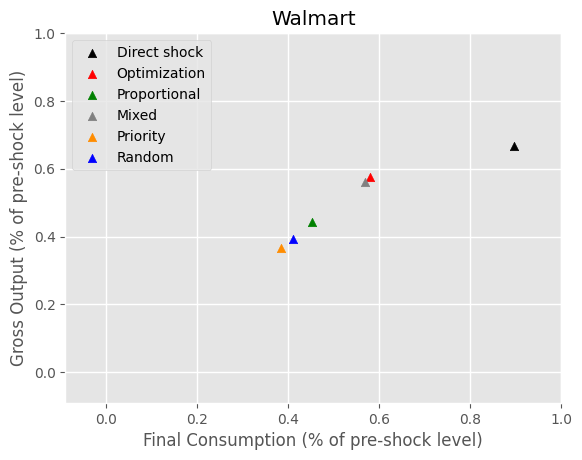

In [30]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.title("Walmart")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.scatter(direct_shock[1], direct_shock[0],marker = '^', color= 'black')
plt.scatter(Max_consumption[1], Max_consumption[0],marker = '^', color= 'red')
#plt.scatter(Max_output[1], Max_output[0], marker = '^', color='orange')
plt.scatter(result_proportional[1], result_proportional[0], marker = '^', color='green')
plt.scatter(result_mixed[1], result_mixed[0], marker = '^', color='grey')
plt.scatter(result_priority[1], result_priority[0], marker = '^', color='darkorange')
plt.scatter(result_random[1], result_random[0],marker = '^', color= 'blue')


plt.xlim(-0.09, 1) 
plt.ylim(-0.09, 1)
plt.legend(['Direct shock', 'Optimization','Proportional','Mixed', 'Priority', 'Random'])
plt.xlabel("Final Consumption (% of pre-shock level)")
plt.ylabel("Gross Output (% of pre-shock level)")

plt.savefig('plot_Walmart.png')
plt.show()

## Shock magnitude 

In [31]:
def shockscale(x, xmax, f, fmax, scale_x, scale_f):
    ss_full = np.divide(xmax,x)-1
    ds_full = np.divide(fmax,f)-1
    
    ss = ss_full*scale_x
    
    x_shocked = np.zeros(N)
    
    for i in range (0,N):
        x_shocked[i] = (np.ones(N)+ ss)[i]*x[i]

    
    ds = ds_full*scale_f
    f_shocked = np.zeros(N)
    
    for i in range (0,N):
        f_shocked[i] = (np.ones(N)+ ds)[i]*f[i]
    
    return x_shocked, f_shocked

In [32]:
def scale_run_direct_shock(scalewhat = "both", seq = np.linspace(0,1,100)):    
    res_dir_x = []
    res_dir_f = []
    for i in range(0, len(seq)):
        if scalewhat == "both":
            scaleres = shockscale(x, x_max, f, f_max, scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x, x_max, f, f_max, scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x, x_max, f, f_max, scale_x=0, scale_f=seq[i])
            
    
        res_dir_x.append(sum(scaleres[0])/sum(x))
        res_dir_f.append(sum(scaleres[1])/sum(f)) 
    dataframe = {'x': res_dir_x,
                 'f': res_dir_f,
                'Scale': scalewhat, 'Algorithm': 'Direct_shock', 'a': seq}
    df = pd.DataFrame(dataframe)
        
    return df

In [33]:
x_direct_D = np.array(scale_run_direct_shock(scalewhat = "demand",  seq = np.linspace(0,1,100)).iloc[:,0].astype('float'))
a_direct_D = np.array(scale_run_direct_shock(scalewhat = "demand",  seq = np.linspace(0,1,100)).iloc[:,4].astype('float'))

In [34]:
TT = 30

In [35]:
def scale_run_rationing(scalewhat = "both",  seq = np.linspace(0,1,100)):
    res1x = []
    res1f = []
    
    res2x = []
    res2f = []
    
    res3x = []
    res3f = []
    i=0
    while i <len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x, x_max, f, f_max,scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x, x_max, f, f_max,scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x, x_max, f, f_max,scale_x=0, scale_f=seq[i])
        
        res1 = algo_proportional(A, L, scaleres[1], scaleres[0], TT, prioritize = "no")
        res2 = algo_mixed(A, L, scaleres[1], scaleres[0],TT, prioritize="yes")
        
        names_ordered = order(A,L,scaleres[1])
        res3 = algo_priority(A, L, scaleres[1], scaleres[0], names_ordered, TT, prioritize="yes")
        
        if res1[2] != 100:
            res1x.append(res1[0])
            res1f.append(res1[1])
        else:
            res1x.append('NaN')
            res1f.append('NaN')
        
        if res2[2] != 100:
            res2x.append(res2[0])
            res2f.append(res2[1])
        else:
            res2x.append('NaN')
            res2f.append('NaN')
            
        if res3[2] != 100:
            res3x.append(res3[0])
            res3f.append(res3[1])
        else:
            res2x.append('NaN')
            res2f.append('NaN')
        i= i+1
    
    dataframe1 = {'x': res1x, 'f': res1f, 'Scale': scalewhat, 'Algorithm': 'Proportional', 'a': seq }
    df1 = pd.DataFrame(dataframe1)
    
    dataframe2 = {'x': res2x, 'f': res2f, 'Scale': scalewhat, 'Algorithm': 'Mixed', 'a': seq }
    df2 = pd.DataFrame(dataframe2)
    
    dataframe3 = {'x': res3x, 'f': res3f, 'Scale': scalewhat, 'Algorithm': 'Priority', 'a': seq }  
    df3 = pd.DataFrame(dataframe3)
    
    return df1, df2, df3

In [36]:
def scale_run_random_rationing(scalewhat = "both", seq = np.linspace(0,1,100)):
    res4x = []
    res4f = []
    i=0
    while i < len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x, x_max, f, f_max,scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x, x_max, f, f_max,scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x, x_max, f, f_max,scale_x=0, scale_f=seq[i])
        
        
        res4 = algo_random(A, L, scaleres[1], scaleres[0], 50, prioritize = "random")
        res4x.append(res4[0])
        res4f.append(res4[1]) 
        
        print(i)
        i = i+1
    
    dataframe4 = {'x': res4x, 'f': res4f, 'Scale': scalewhat, 'Algorithm': 'Random', 'a': seq}  
    df4 = pd.DataFrame(dataframe4)
    
    return df4

In [37]:
def scale_run_optimizationX(scalewhat = "both", runs = 100, seq = np.linspace(0,1,100)):
    resmax_output_x = []
    resmax_output_f = []
    
    i=0
    while i <len(seq):
        if scalewhat == "both":
            scaleres = shockscale(x, x_max, f, f_max, scale_x=seq[i], scale_f=seq[i])
            
        if scalewhat == "supply":
            scaleres = shockscale(x, x_max, f, f_max, scale_x=seq[i], scale_f=0)
            
        if scalewhat == "demand":
            scaleres = shockscale(x, x_max, f, f_max, scale_x=0, scale_f=seq[i])
        
        #print(scaleres[0])
        resmaxX = max_output(N , L, A, xmax = scaleres[0], fmax=scaleres[1])
        #print(resmaxX)
        if resmaxX[0] == True:
        #print(resmaxX)
            resmax_output_x.append(resmaxX[1])
            resmax_output_f.append(resmaxX[2])
        else: 
            resmax_output_x.append('NaN')
            resmax_output_f.append('NaN')
            
            
        i = i+1
        
        
    dataframe = {'x': resmax_output_x,
                 'f': resmax_output_f,
                'Scale': scalewhat, 'Algorithm': 'Max_output', 'a': seq}
    df = pd.DataFrame(dataframe)
    
    return df

In [38]:
x_opt_D = np.array(scale_run_optimizationX(scalewhat = "demand",  seq = np.linspace(0,1,100)).iloc[:,0].astype('float'))
a_opt_D = np.array(scale_run_optimizationX(scalewhat = "demand",  seq = np.linspace(0,1,100)).iloc[:,4].astype('float'))

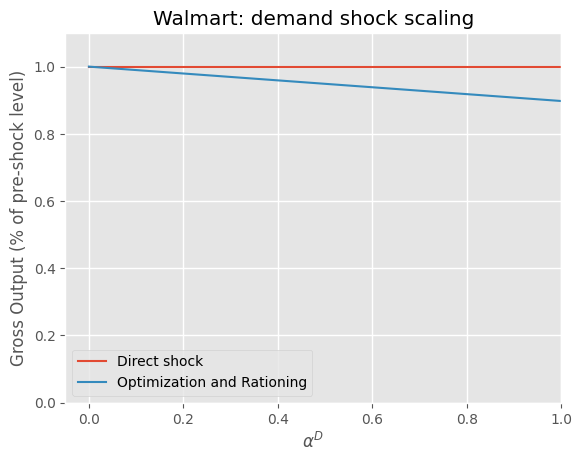

In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.title("Walmart: demand shock scaling")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)
plt.plot(a_direct_D, x_direct_D)
plt.plot(a_opt_D, x_opt_D)
plt.xlim(-0.05, 1) 
plt.ylim(-0.00,1.1)

#plt.rcParams['text.usetex'] = True
plt.xlabel(r'$\alpha^D$')
plt.ylabel("Gross Output (% of pre-shock level)")
plt.legend(['Direct shock', 'Optimization and Rationing'])
plt.savefig('plot_Walmart_scale_demand.png')

In [40]:
result_direct = scale_run_direct_shock(scalewhat = "supply",  seq = np.linspace(0,1,100)) #ok: zelfde resultaat
x_direct = np.array(result_direct.iloc[:,0].astype('float'))
a_direct = np.array(result_direct.iloc[:,4].astype('float'))

result_opt = scale_run_optimizationX(scalewhat = "supply", runs = 100, seq = np.linspace(0,1,100)) #ok 
x_opt= np.array(result_opt.iloc[:,0].astype('float'))
a_opt = np.array(result_opt.iloc[:,4].astype('float'))


result_prop = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[0] #ok: zelfde resultaat
x_prop = np.array(result_prop.iloc[:,0].astype('float'))
a_prop = np.array(result_prop.iloc[:,4].astype('float'))

result_mixed = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[1] #ok: zelfde resultaat
x_mixed = np.array(result_mixed.iloc[:,0].astype('float'))
a_mixed = np.array(result_mixed.iloc[:,4].astype('float'))

result_priority = scale_run_rationing(scalewhat = "supply",  seq = np.linspace(0,1,100))[2]
x_priority = np.array(result_priority.iloc[:,0].astype('float'))
a_priority = np.array(result_priority.iloc[:,4].astype('float'))

In [41]:
result_random = scale_run_random_rationing(scalewhat = "supply", seq = np.linspace(0,1,100))
x_random = np.array(result_random.iloc[:,0].astype('float'))
a_random = np.array(result_random.iloc[:,4].astype('float'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


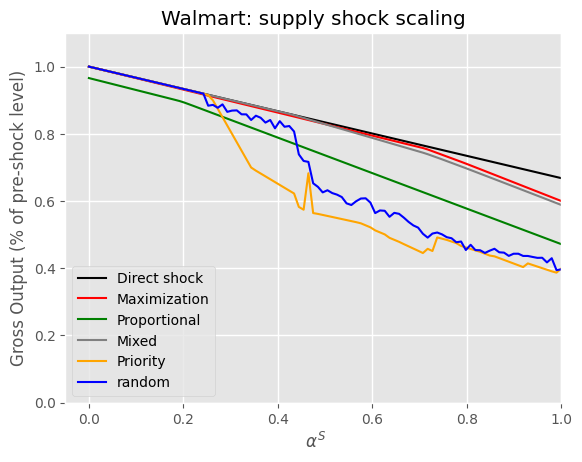

In [42]:
plt.style.use('ggplot')
plt.title("Walmart: supply shock scaling")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.plot(a_direct, x_direct, 'black')
plt.plot(a_opt, x_opt, 'red')
plt.plot(a_prop, x_prop, 'green')
plt.plot(a_mixed, x_mixed, 'grey')
plt.plot(a_priority, x_priority, 'orange')
plt.plot(a_random, x_random, 'blue')

plt.xlim(-0.05, 1) 
plt.ylim(-0.00,1.1)
#plt.rcParams['text.usetex'] = True
plt.xlabel(r' $\alpha^S$')
plt.ylabel("Gross Output (% of pre-shock level)")
plt.legend(['Direct shock', 'Maximization', 'Proportional', 'Mixed', 'Priority', 'random'])
plt.savefig('plot_Walmart_scale.png')